# PEZ Grid Search Results Analysis (Lambda Variation)

This notebook analyzes PEZ grid search results, focusing on lambda variation with multiple learning rates.


In [6]:
import json
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

plt.style.use('seaborn-v0_8')
%matplotlib inline


In [7]:
# Base directory
base_dir = "/mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test"
non_adv_dir = os.path.join(base_dir, "adversarial_false")

print(f"Results directory: {base_dir}")
print(f"Non-adversarial directory: {non_adv_dir}")


Results directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test
Non-adversarial directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test/adversarial_false


In [8]:
def load_all_histories(directory):
    """Load all history JSON files from a directory."""
    histories = {}
    
    # Find all history files
    history_files = glob.glob(os.path.join(directory, "history_*.json"))
    
    for filepath in history_files:
        # Parse filename: history_lambda_{lambda}_lr_{lr}.json
        filename = os.path.basename(filepath)
        match = re.match(r"history_lambda_([0-9.]+)_lr_([0-9.e-]+)\.json", filename)
        
        if match:
            lambda_val = float(match.group(1))
            lr_val = float(match.group(2))
            
            with open(filepath, 'r') as f:
                history = json.load(f)
            
            key = (lambda_val, lr_val)
            histories[key] = history
            print(f"Loaded: lambda={lambda_val}, lr={lr_val}")
    
    return histories


In [9]:
# Load histories
print("Loading non-adversarial histories...")
non_adv_histories = load_all_histories(non_adv_dir)

print(f"\nNon-adversarial: {len(non_adv_histories)} runs")


Loading non-adversarial histories...
Loaded: lambda=0.25, lr=0.0001
Loaded: lambda=0.25, lr=0.001
Loaded: lambda=0.25, lr=0.01
Loaded: lambda=0.5, lr=0.0001
Loaded: lambda=0.5, lr=0.001
Loaded: lambda=0.5, lr=0.01
Loaded: lambda=0.75, lr=0.0001
Loaded: lambda=0.75, lr=0.001
Loaded: lambda=0.75, lr=0.01
Loaded: lambda=1.0, lr=0.0001
Loaded: lambda=1.0, lr=0.001
Loaded: lambda=1.0, lr=0.01

Non-adversarial: 12 runs


In [10]:
def plot_learning_curves(histories, title_prefix="", max_epochs=None, select_best_lr=True):
    """Plot learning curves for PEZ, grouped by learning rate.
    
    Args:
        histories: Dictionary of histories with keys (lambda, lr)
        title_prefix: Prefix for plot titles
        max_epochs: Maximum number of epochs to plot (None = plot all)
        select_best_lr: If True, select LR with best final acc for each lambda
    """
    
    if not histories:
        print("No histories to plot")
        return []
    
    # If select_best_lr, filter to keep only the best LR for each lambda
    if select_best_lr:
        # Group by lambda
        lambda_values = sorted(set(k[0] for k in histories.keys()))
        filtered_histories = {}
        
        for lam in lambda_values:
            # Get all histories for this lambda
            lam_histories = {(lam_val, lr): h for (lam_val, lr), h in histories.items() if lam_val == lam}
            
            # Select LR with BEST final accuracy
            best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            
            filtered_histories[best_key[0]] = best_key[1]
        
        histories = filtered_histories
        print(f"Selected best LR for each lambda")
    
    # Group by learning rate (since we're varying lambda)
    lr_values = sorted(set(k[1] for k in histories.keys()))
    lambda_values = sorted(set(k[0] for k in histories.keys()))
    
    figs = []
    
    for lr in lr_values:
        # Filter histories for this learning rate
        lr_histories = {(lam, lr_val): h for (lam, lr_val), h in histories.items() if lr_val == lr}
        
        if not lr_histories:
            continue
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"{title_prefix}PEZ Learning Curves - LR={lr:.0e}", fontsize=16, fontweight='bold')
        
        # Plot 1: Training Task Loss
        ax1 = axes[0, 0]
        for (lam, lr_val), history in sorted(lr_histories.items()):
            if 'train_task' in history:
                data = history['train_task'][:max_epochs] if max_epochs else history['train_task']
                epochs = range(1, len(data) + 1)
                ax1.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Task Loss')
        ax1.set_title(f'PEZ: Training Task Loss (LR={lr:.0e})')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Validation Loss
        ax2 = axes[0, 1]
        for (lam, lr_val), history in sorted(lr_histories.items()):
            data = history['val_loss'][:max_epochs] if max_epochs else history['val_loss']
            epochs = range(1, len(data) + 1)
            ax2.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Loss')
        ax2.set_title(f'PEZ: Validation Loss (LR={lr:.0e})')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Accuracy
        ax3 = axes[1, 0]
        for (lam, lr_val), history in sorted(lr_histories.items()):
            data = history['val_acc'][:max_epochs] if max_epochs else history['val_acc']
            epochs = range(1, len(data) + 1)
            ax3.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Accuracy')
        ax3.set_title(f'PEZ: Validation Accuracy (LR={lr:.0e})')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Prompt Perplexity
        ax4 = axes[1, 1]
        for (lam, lr_val), history in sorted(lr_histories.items()):
            if 'prompt_ppl_ppx' in history:
                data = history['prompt_ppl_ppx'][:max_epochs] if max_epochs else history['prompt_ppl_ppx']
                epochs = range(1, len(data) + 1)
                ax4.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Prompt Perplexity')
        ax4.set_title(f'PEZ: Prompt Perplexity (LR={lr:.0e})')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs


Plotting non-adversarial PEZ learning curves (best LR selected)...
Selected best LR for each lambda


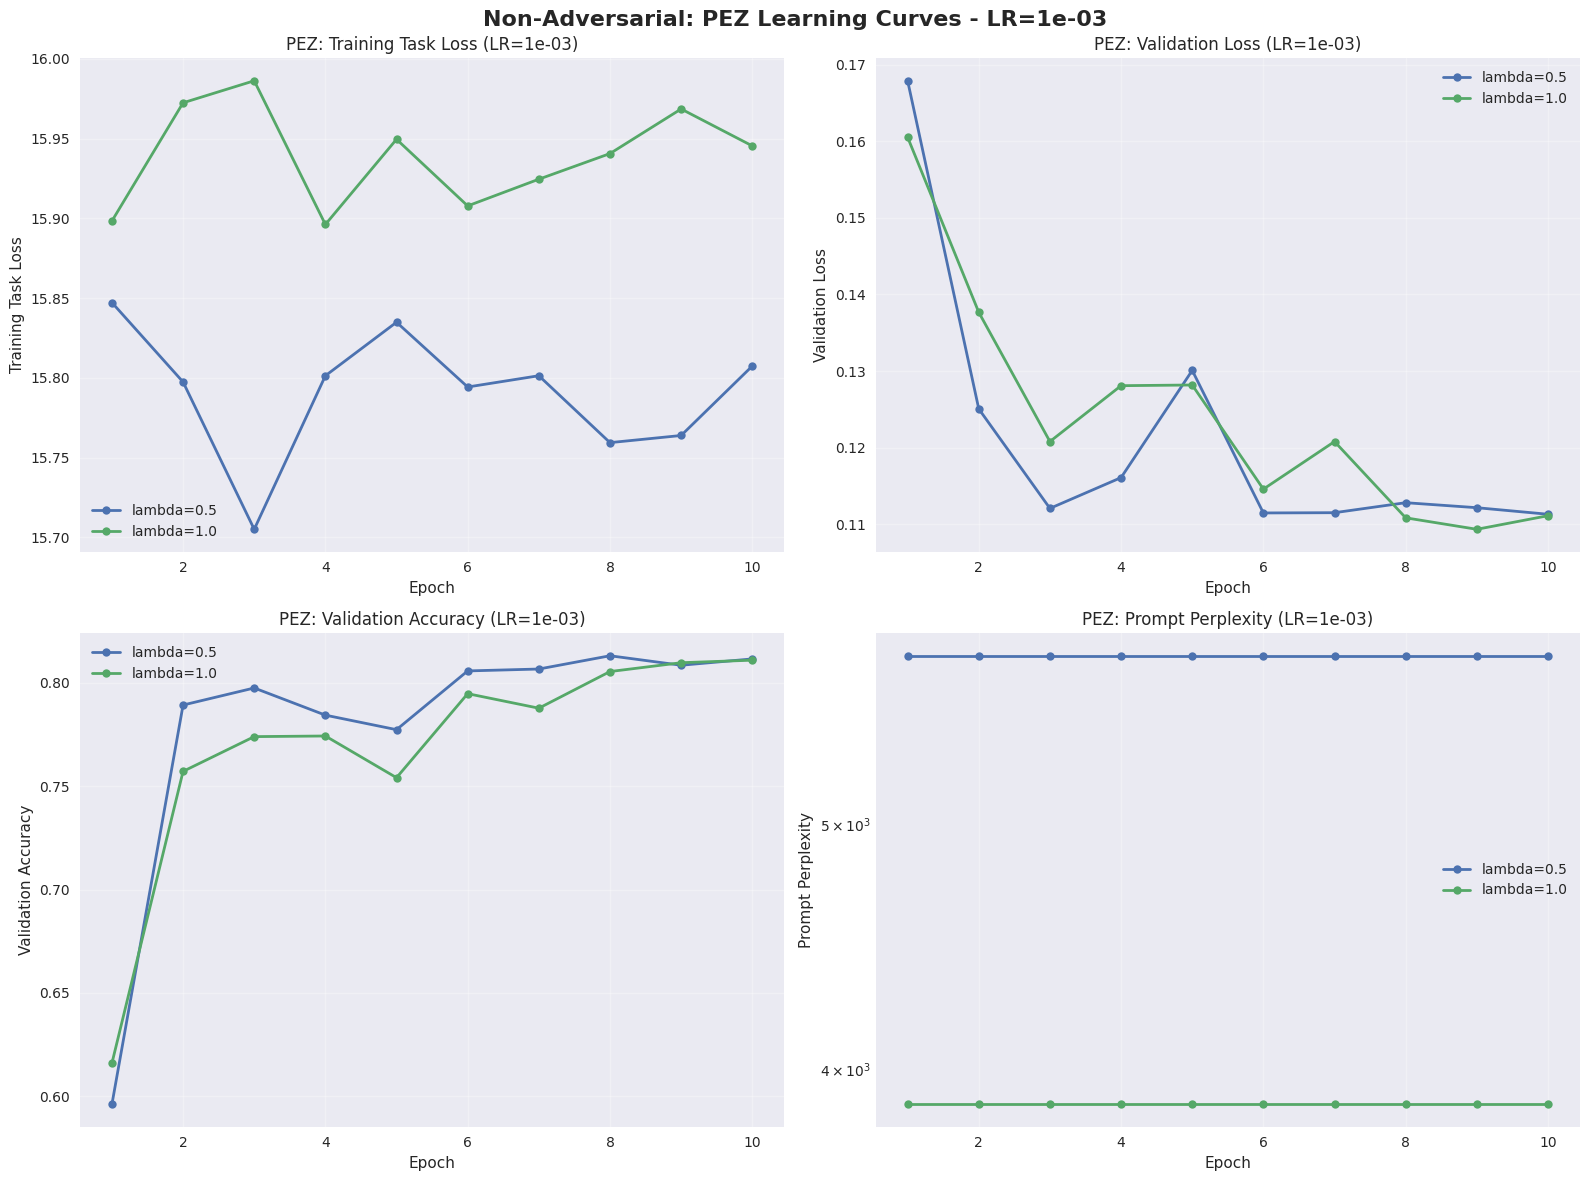

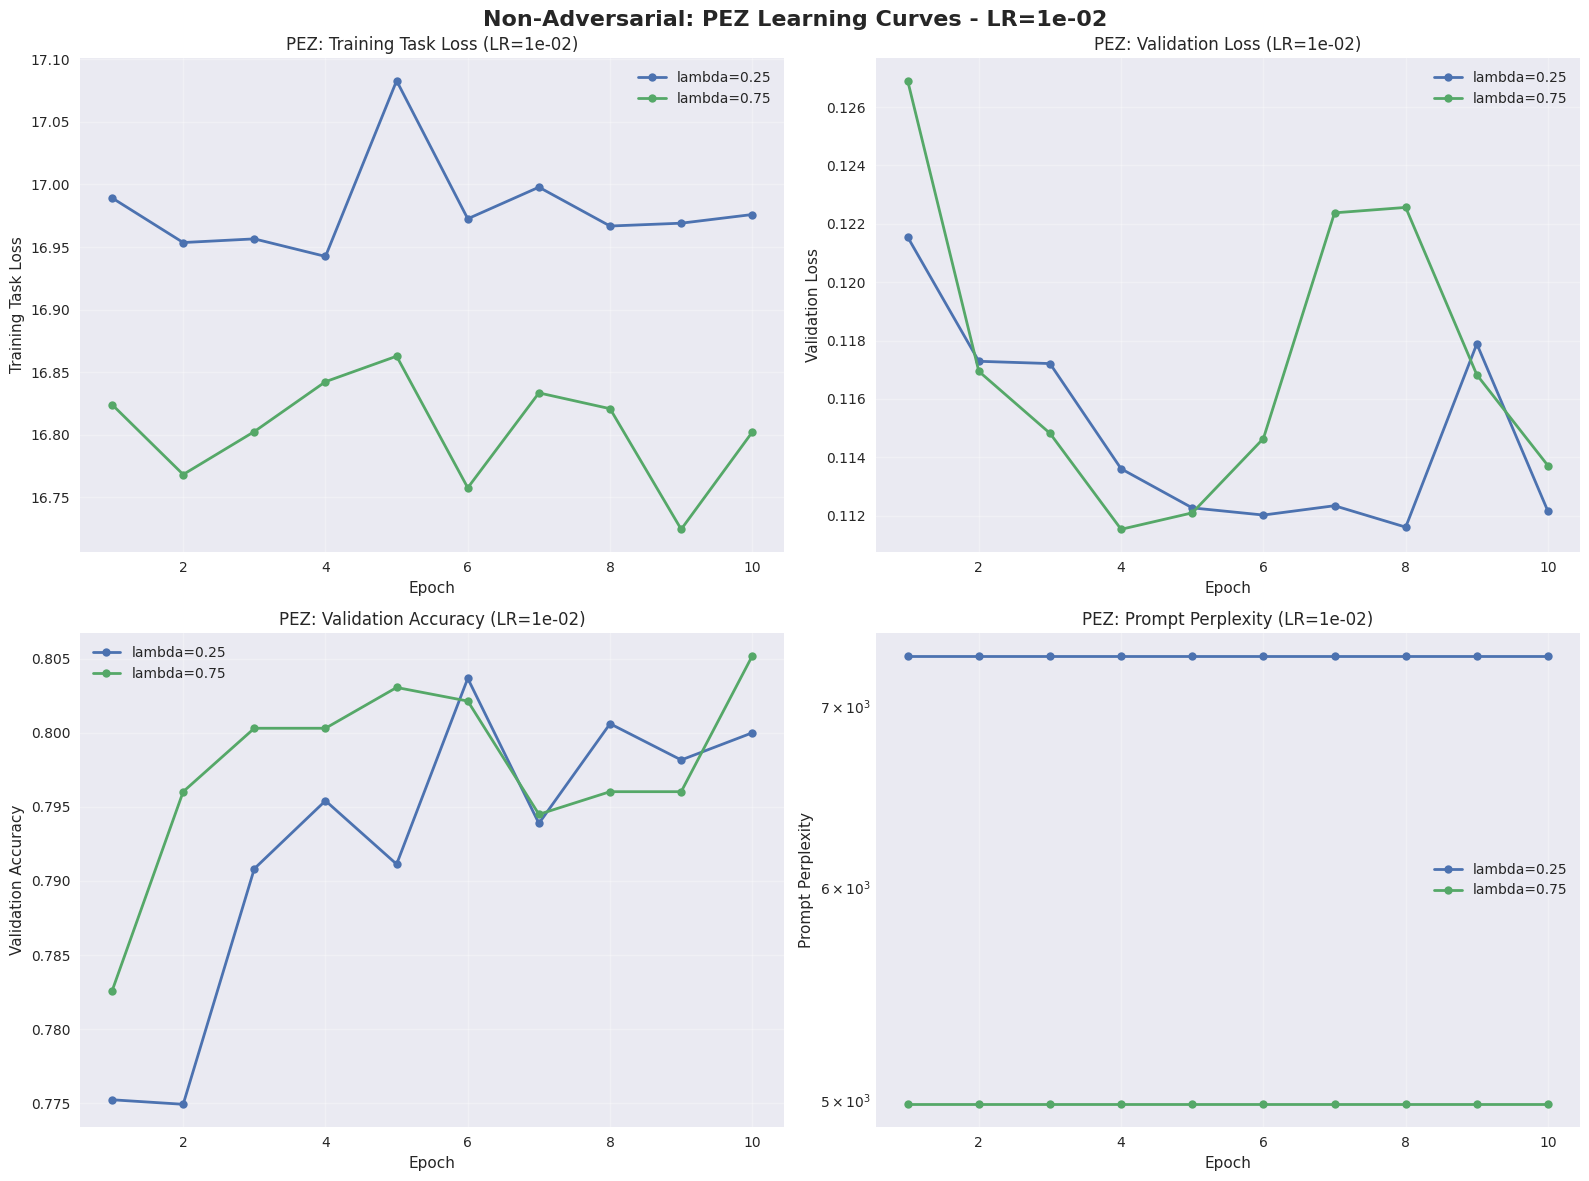

In [11]:
# Plot non-adversarial learning curves (select best LR for each lambda)
print("Plotting non-adversarial PEZ learning curves (best LR selected)...")
if non_adv_histories:
    figs_non_adv = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ", select_best_lr=True)
    for fig in figs_non_adv:
        plt.show()
else:
    print("No non-adversarial PEZ histories found")


Plotting non-adversarial PEZ learning curves (one plot per LR)...


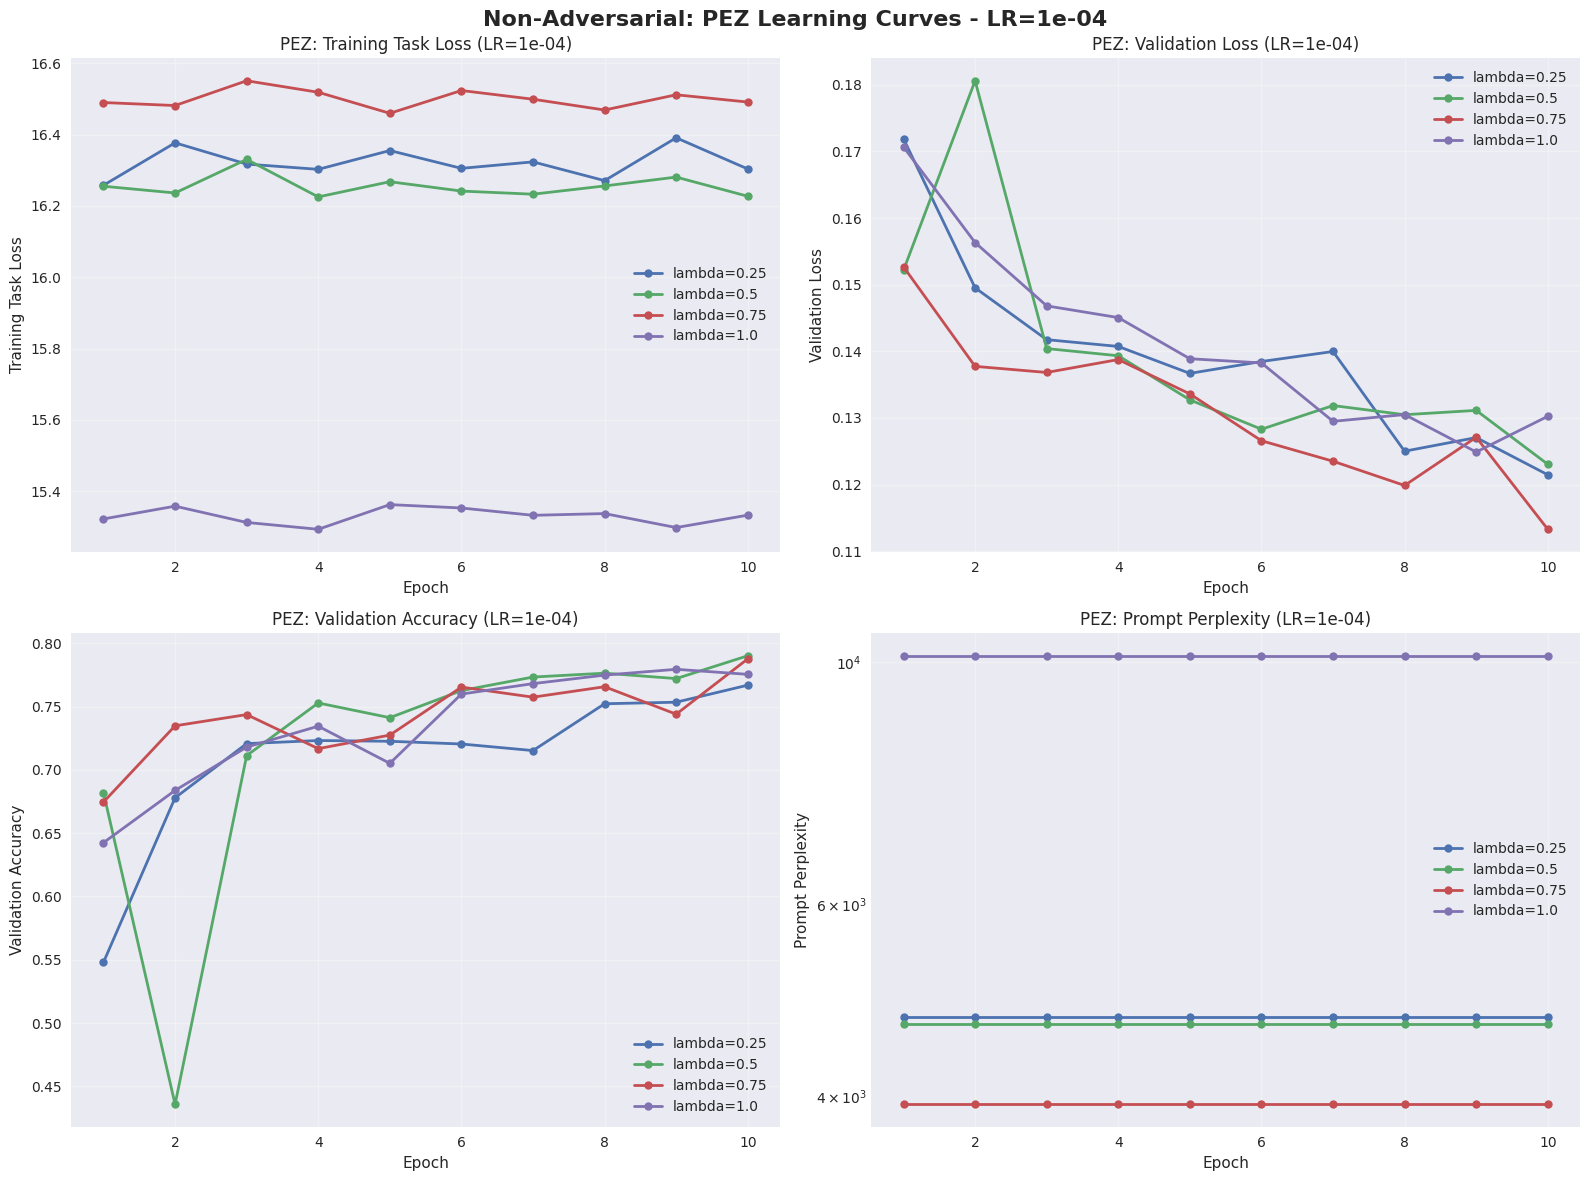

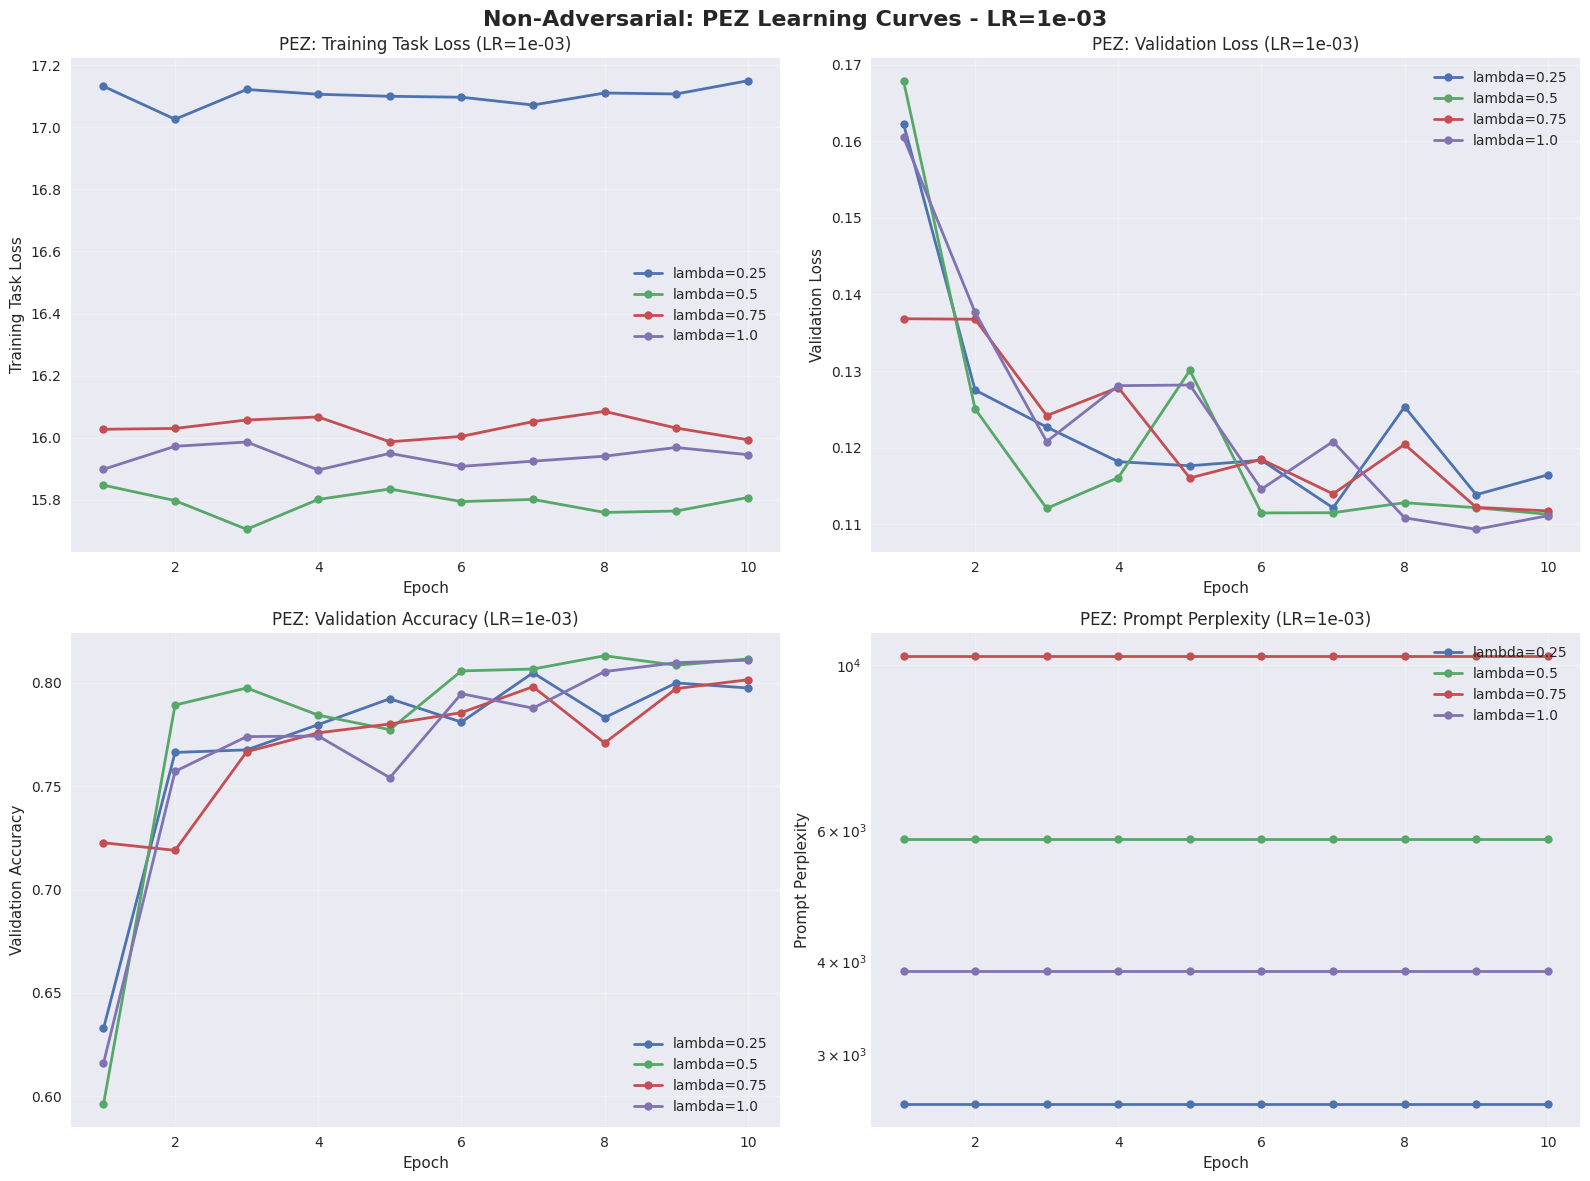

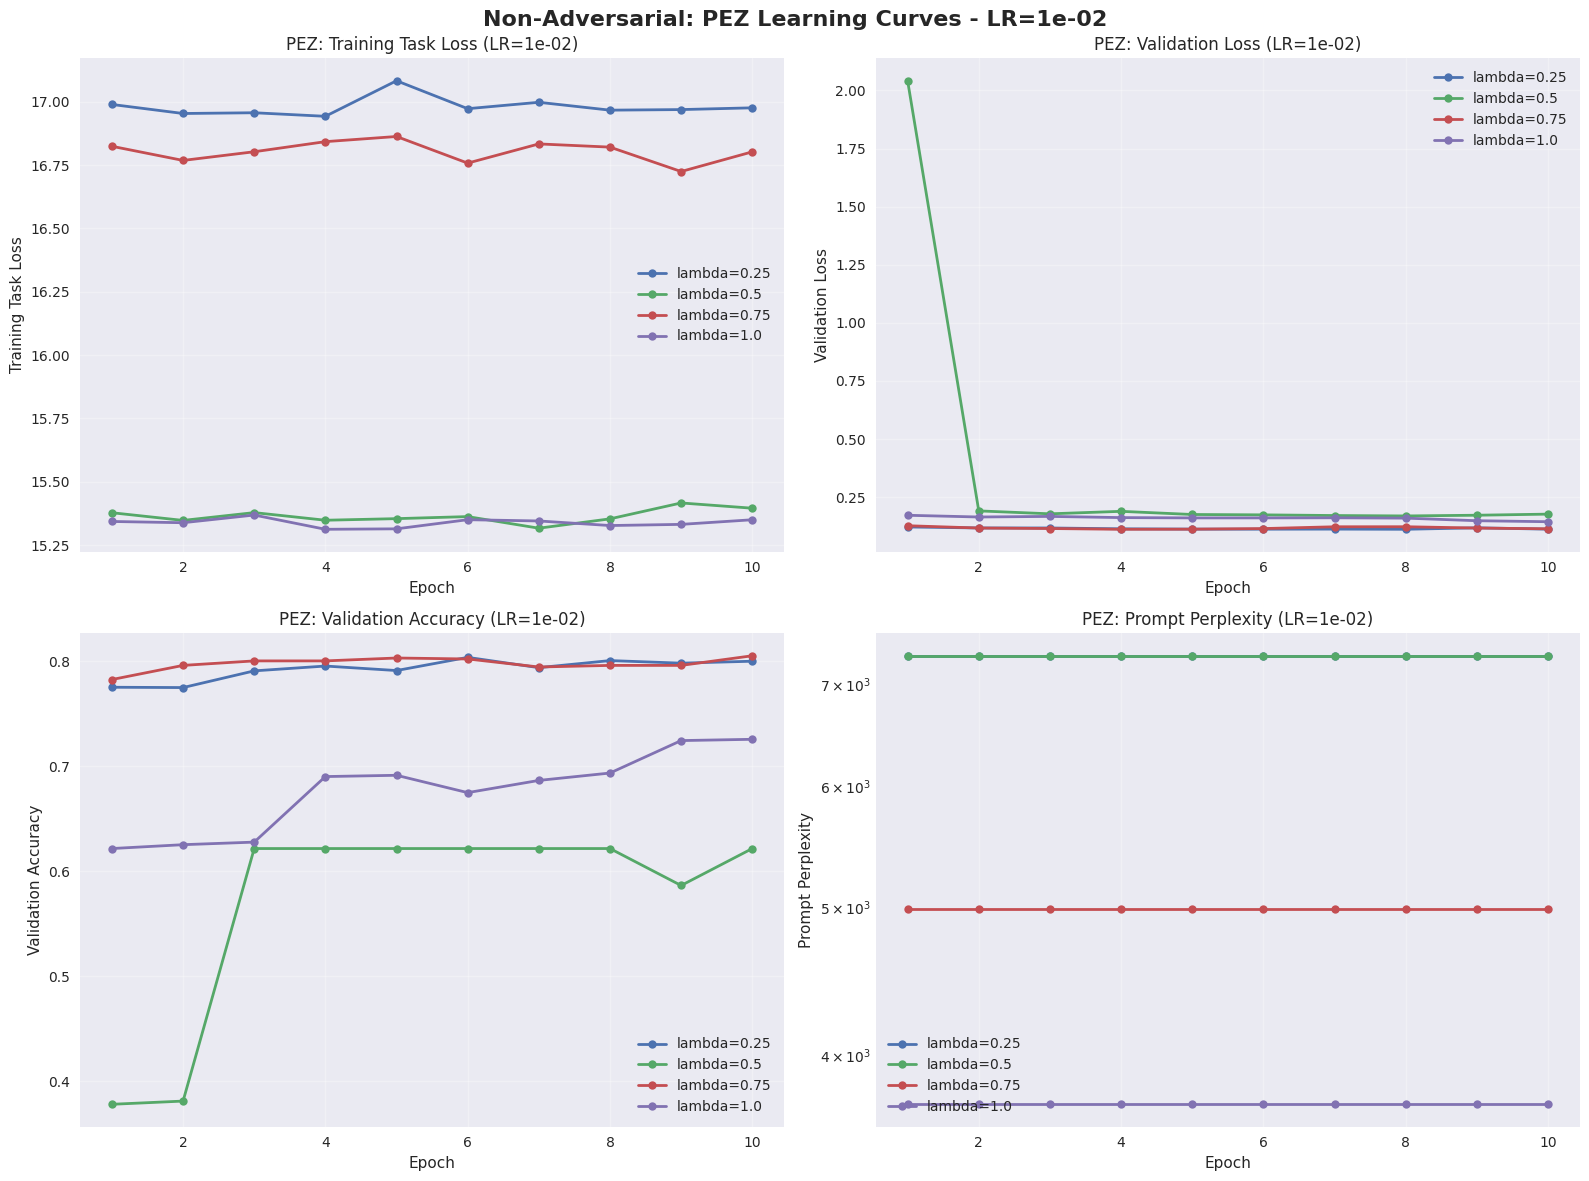

In [12]:
# Plot non-adversarial learning curves (one plot per LR, showing all lambdas)
print("Plotting non-adversarial PEZ learning curves (one plot per LR)...")
if non_adv_histories:
    figs_non_adv_all = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ", select_best_lr=False)
    for fig in figs_non_adv_all:
        plt.show()
else:
    print("No non-adversarial PEZ histories found")


In [ ]:
# Summary table
print("\n" + "=" * 80)
print("PEZ: SUMMARY TABLE")
print("=" * 80)

summary_data = []

for (lam, lr), history in sorted(non_adv_histories.items()):
    best_val_acc = max(history['val_acc'])
    final_val_acc = history['val_acc'][-1]
    best_true_acc = max(history['val_acc_true'])
    best_false_acc = max(history['val_acc_false'])
    final_prompt_ppl = history['prompt_ppl_ppx'][-1] if 'prompt_ppl_ppx' in history else None
    
    summary_data.append({
        'Lambda': lam,
        'Learning Rate': f"{lr:.0e}",
        'Best Val Acc': best_val_acc,
        'Final Val Acc': final_val_acc,
        'Best True Acc': best_true_acc,
        'Best False Acc': best_false_acc,
        'Final Prompt PPL': final_prompt_ppl
    })

df = pd.DataFrame(summary_data)
print(df.to_string(index=False))


In [ ]:
# Comparison plot: Best accuracy vs Lambda
# For non-adversarial: use LR with best final accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('PEZ: Accuracy vs Lambda', fontsize=16, fontweight='bold', y=1.02)

# Non-adversarial
if non_adv_histories:
    ax1 = axes[0]
    lambda_values = sorted(set(k[0] for k in non_adv_histories.keys()))
    best_accs = []
    final_accs = []
    for lam in lambda_values:
        # Get all histories for this lambda
        lam_histories = {(lam_val, lr): h for (lam_val, lr), h in non_adv_histories.items() if lam_val == lam}
        # Select LR with BEST final accuracy
        best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
        history = best_key[1]
        best_accs.append(max(history['val_acc']))
        final_accs.append(history['val_acc'][-1])
    
    ax1.plot(lambda_values, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax1.plot(lambda_values, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax1.set_xlabel('Lambda', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('Non-Adversarial PEZ (Best LR)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

# Prompt Perplexity vs Lambda
if non_adv_histories:
    ax2 = axes[1]
    lambda_values = sorted(set(k[0] for k in non_adv_histories.keys()))
    final_ppls = []
    for lam in lambda_values:
        # Get all histories for this lambda
        lam_histories = {(lam_val, lr): h for (lam_val, lr), h in non_adv_histories.items() if lam_val == lam}
        # Select LR with BEST final accuracy
        best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
        history = best_key[1]
        final_ppls.append(history['prompt_ppl_ppx'][-1] if 'prompt_ppl_ppx' in history else None)
    
    ax2.plot(lambda_values, final_ppls, marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('Lambda', fontsize=12)
    ax2.set_ylabel('Final Prompt Perplexity', fontsize=12)
    ax2.set_title('Non-Adversarial PEZ: Prompt Perplexity (Best LR)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# Create table: Lambda vs Epoch (Validation Accuracy)
def create_epoch_accuracy_table(histories, metric='val_acc', select_best_lr=True):
    """Create a table with lambdas as rows and epochs as columns.
    
    Args:
        histories: Dictionary of histories with keys (lambda, lr)
        metric: Which metric to use ('val_acc', 'val_acc_true', 'val_acc_false')
        select_best_lr: If True, select LR with best final acc for each lambda
    """
    
    if not histories:
        return None
    
    # If select_best_lr, filter to keep only the best LR for each lambda
    if select_best_lr:
        # Group by lambda
        lambda_values = sorted(set(k[0] for k in histories.keys()))
        filtered_histories = {}
        
        for lam in lambda_values:
            # Get all histories for this lambda
            lam_histories = {(l, lr): h for (l, lr), h in histories.items() if l == lam}
            
            # Select LR with BEST final accuracy
            best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            
            filtered_histories[best_key[0]] = best_key[1]
        
        histories = filtered_histories
    
    # Get all lambdas and find max epochs
    lambda_values = sorted(set(k[0] for k in histories.keys()))
    max_epochs = 0
    
    # Find maximum number of epochs across all histories
    for (lam, lr), history in histories.items():
        if metric in history:
            max_epochs = max(max_epochs, len(history[metric]))
    
    # Create table data
    table_data = []
    for lam in lambda_values:
        # Find a history for this lambda
        row_data = {'Lambda': lam}
        for (lam_val, lr), history in histories.items():
            if lam_val == lam and metric in history:
                # Fill in accuracies for each epoch
                for epoch_idx, acc in enumerate(history[metric], start=1):
                    row_data[f'Epoch {epoch_idx}'] = acc
                break
        table_data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    # Reorder columns: Lambda first, then epochs
    cols = ['Lambda'] + [f'Epoch {i}' for i in range(1, max_epochs + 1)]
    df = df.reindex(columns=[c for c in cols if c in df.columns])
    
    return df

# Create tables for non-adversarial (using best LR for each lambda)
print("\n" + "=" * 80)
print("NON-ADVERSARIAL: Overall Validation Accuracy by Lambda and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_total = create_epoch_accuracy_table(non_adv_histories, metric='val_acc', select_best_lr=True)
    if df_non_adv_total is not None:
        print(df_non_adv_total.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: True (Yes) Accuracy by Lambda and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_true = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_true', select_best_lr=True)
    if df_non_adv_true is not None:
        print(df_non_adv_true.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: False (No) Accuracy by Lambda and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_false = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_false', select_best_lr=True)
    if df_non_adv_false is not None:
        print(df_non_adv_false.to_string(index=False))
else:
    print("No non-adversarial histories found")
